## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from datetime import date
from functools import reduce
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

## Read Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/online_retail_customer_churn.csv', encoding='cp1252')
pd.set_option('display.max_columns', None)
data.head()

,Customer_ID,Age,Gender,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Num_of_Support_Contacts,Satisfaction_Score,Last_Purchase_Days_Ago,Email_Opt_In,Promotion_Response,Target_Churn
0,1,62,Other,45.15,5892.58,5,22,453.80,2,0,3,129,True,Responded,True
1,2,65,Male,79.51,9025.47,13,77,22.90,2,2,3,227,False,Responded,False
2,3,18,Male,29.19,618.83,13,71,50.53,5,2,2,283,False,Responded,True
3,4,21,Other,79.63,9110.30,3,33,411.83,5,3,5,226,True,Ignored,True
4,5,21,Other,77.66,5390.88,15,43,101.19,3,0,5,242,False,Unsubscribed,False


## Data Preprocessing

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer_ID                 1000 non-null   int64  
 1   Age                         1000 non-null   int64  
 2   Gender                      1000 non-null   object 
 3   Annual_Income               1000 non-null   float64
 4   Total_Spend                 1000 non-null   float64
 5   Years_as_Customer           1000 non-null   int64  
 6   Num_of_Purchases            1000 non-null   int64  
 7   Average_Transaction_Amount  1000 non-null   float64
 8   Num_of_Returns              1000 non-null   int64  
 9   Num_of_Support_Contacts     1000 non-null   int64  
 10  Satisfaction_Score          1000 non-null   int64  
 11  Last_Purchase_Days_Ago      1000 non-null   int64  
 12  Email_Opt_In                1000 non-null   bool   
 13  Promotion_Response          1000 n

In [5]:
print("Jumlah duplikasi data : " + str(data.duplicated().sum()))

Jumlah duplikasi data : 0


In [6]:
label_enc = { "Email_Opt_In": {True: 1, False: 0},}
data = data.replace(label_enc)

In [7]:
def check_outliers(df, col):
  col_Q3 = df[col].quantile(0.75)
  col_Q1 = df[col].quantile(0.25)
  col_IQR = col_Q3 - col_Q1
  col_RLB = col_Q1 - 1.5 * col_IQR
  col_RUB = col_Q3 + 1.5 * col_IQR
  col_outlier_df = df.loc[(df[col] < col_RLB) | (df[col] > col_RUB)]
  print(f"Number of outliers in attribute {col}: {len(col_outlier_df)}")
  print(f"Proportion of outliers in attribute {col}: {len(col_outlier_df)/df[col].count()*100}\n")

  return int(len(col_outlier_df))

In [8]:
outlier_col = []
for num_col in data.select_dtypes(np.number).columns:
  outlier = check_outliers(data, num_col)
  if(outlier > 0):
    outlier_col.append(num_col)

Number of outliers in attribute Customer_ID: 0
Proportion of outliers in attribute Customer_ID: 0.0

Number of outliers in attribute Age: 0
Proportion of outliers in attribute Age: 0.0

Number of outliers in attribute Annual_Income: 0
Proportion of outliers in attribute Annual_Income: 0.0

Number of outliers in attribute Total_Spend: 0
Proportion of outliers in attribute Total_Spend: 0.0

Number of outliers in attribute Years_as_Customer: 0
Proportion of outliers in attribute Years_as_Customer: 0.0

Number of outliers in attribute Num_of_Purchases: 0
Proportion of outliers in attribute Num_of_Purchases: 0.0

Number of outliers in attribute Average_Transaction_Amount: 0
Proportion of outliers in attribute Average_Transaction_Amount: 0.0

Number of outliers in attribute Num_of_Returns: 0
Proportion of outliers in attribute Num_of_Returns: 0.0

Number of outliers in attribute Num_of_Support_Contacts: 0
Proportion of outliers in attribute Num_of_Support_Contacts: 0.0

Number of outliers in

## Feature Scaling

In [9]:
normalize = MinMaxScaler()

exclude_col = ['Customer_ID', 'Gender', 'Email_Opt_In',	'Target_Churn', 'Promotion_Response']
col_to_scale = data.columns.difference(exclude_col)
data_scaled = data.copy()
data_scaled[col_to_scale] = normalize.fit_transform(data_scaled[col_to_scale])
data_scaled = pd.DataFrame(data_scaled, columns=data_scaled.columns)

data_scaled

,Customer_ID,Age,Gender,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Num_of_Support_Contacts,Satisfaction_Score,Last_Purchase_Days_Ago,Email_Opt_In,Promotion_Response,Target_Churn
0,1,0.862745,Other,0.139884,0.584755,0.222222,0.214286,0.906422,0.222222,0.00,0.50,0.352617,1,Responded,True
1,2,0.921569,Male,0.331071,0.901506,0.666667,0.775510,0.025434,0.222222,0.50,0.50,0.622590,0,Responded,False
2,3,0.000000,Male,0.051079,0.051552,0.666667,0.714286,0.081924,0.555556,0.50,0.25,0.776860,0,Responded,True
3,4,0.058824,Other,0.331738,0.910083,0.111111,0.326531,0.820613,0.555556,0.75,1.00,0.619835,1,Ignored,True
4,5,0.058824,Other,0.320777,0.534031,0.777778,0.428571,0.185500,0.333333,0.00,1.00,0.663912,0,Unsubscribed,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,0.705882,Male,0.688349,0.099098,0.055556,0.285714,0.137576,0.000000,0.75,0.25,0.239669,1,Ignored,False
996,997,0.019608,Male,0.802248,0.363099,0.444444,0.908163,0.049048,0.666667,1.00,0.75,0.966942,0,Responded,True
997,998,0.568627,Female,0.519141,0.060351,0.888889,0.693878,0.361698,0.777778,0.75,0.00,0.471074,1,Unsubscribed,False
998,999,0.098039,Male,0.294736,0.382446,0.333333,0.306122,0.967758,0.111111,0.50,1.00,0.148760,0,Responded,True


## Numeric Feature Selection

In [10]:
num_col = data_scaled.select_dtypes(include='number')
num_col = num_col.drop('Customer_ID', axis=1)
num_col

,Age,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Num_of_Support_Contacts,Satisfaction_Score,Last_Purchase_Days_Ago,Email_Opt_In
0,0.862745,0.139884,0.584755,0.222222,0.214286,0.906422,0.222222,0.00,0.50,0.352617,1
1,0.921569,0.331071,0.901506,0.666667,0.775510,0.025434,0.222222,0.50,0.50,0.622590,0
2,0.000000,0.051079,0.051552,0.666667,0.714286,0.081924,0.555556,0.50,0.25,0.776860,0
3,0.058824,0.331738,0.910083,0.111111,0.326531,0.820613,0.555556,0.75,1.00,0.619835,1
4,0.058824,0.320777,0.534031,0.777778,0.428571,0.185500,0.333333,0.00,1.00,0.663912,0
...,...,...,...,...,...,...,...,...,...,...,...
995,0.705882,0.688349,0.099098,0.055556,0.285714,0.137576,0.000000,0.75,0.25,0.239669,1
996,0.019608,0.802248,0.363099,0.444444,0.908163,0.049048,0.666667,1.00,0.75,0.966942,0
997,0.568627,0.519141,0.060351,0.888889,0.693878,0.361698,0.777778,0.75,0.00,0.471074,1
998,0.098039,0.294736,0.382446,0.333333,0.306122,0.967758,0.111111,0.50,1.00,0.148760,0


In [11]:
X = num_col
y = data['Target_Churn']

selector = SelectKBest(score_func=f_classif, k='all')
X_new = selector.fit_transform(X, y)

scores = selector.scores_

feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
print(feature_scores)

                       Feature     Score
1                Annual_Income  1.318424
4             Num_of_Purchases  1.073041
3            Years_as_Customer  0.888416
2                  Total_Spend  0.820392
5   Average_Transaction_Amount  0.610391
8           Satisfaction_Score  0.508516
9       Last_Purchase_Days_Ago  0.190717
7      Num_of_Support_Contacts  0.091859
0                          Age  0.085585
10                Email_Opt_In  0.001036
6               Num_of_Returns  0.000004


> Fitur yang akan digunakan adalah fitur dengan score yang berada di atas threshold, yaitu 0,5. Threshold ini kami tentukan karena gap score 0,5 dengan score di bawahnya sudah cukup jauh, yaitu sekitar 0,3. Melalui threshold yang ditentukan, fitur yang akan digunakan adalah annual income, number of purchases, years as customer, total spend, average transaction amount, dan satisfaction score.

In [12]:
selected_feature = data_scaled[['Annual_Income', 'Num_of_Purchases', 'Years_as_Customer', 'Years_as_Customer', 'Total_Spend']]#, 'Average_Transaction_Amount', 'Satisfaction_Score']]
selected_feature

,Annual_Income,Num_of_Purchases,Years_as_Customer,Years_as_Customer,Total_Spend
0,0.139884,0.214286,0.222222,0.222222,0.584755
1,0.331071,0.775510,0.666667,0.666667,0.901506
2,0.051079,0.714286,0.666667,0.666667,0.051552
3,0.331738,0.326531,0.111111,0.111111,0.910083
4,0.320777,0.428571,0.777778,0.777778,0.534031
...,...,...,...,...,...
995,0.688349,0.285714,0.055556,0.055556,0.099098
996,0.802248,0.908163,0.444444,0.444444,0.363099
997,0.519141,0.693878,0.888889,0.888889,0.060351
998,0.294736,0.306122,0.333333,0.333333,0.382446


## Categorical Feature Selection

In [13]:
# Categorical Column

categorical_column = ['Gender', 	'Promotion_Response']
categorical_df = data[categorical_column]
categorical_df

,Gender,Promotion_Response
0,Other,Responded
1,Male,Responded
2,Male,Responded
3,Other,Ignored
4,Other,Unsubscribed
...,...,...
995,Male,Ignored
996,Male,Responded
997,Female,Unsubscribed
998,Male,Responded


In [14]:
# Label encode

label_enc = { "Gender": {"Female": 1, "Male": 0, "Other": 2},
             "Promotion_Response" : {"Unsubscribed": 1, "Responded": 2, "Ignored": 0}}
categorical_df = categorical_df.replace(label_enc)

In [15]:
target = data['Target_Churn']
target

0       True
1      False
2       True
3       True
4      False
       ...  
995    False
996     True
997    False
998     True
999     True
Name: Target_Churn, Length: 1000, dtype: bool

In [16]:
# Fit SelectKBest

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(categorical_df,target)

In [17]:
scores = fit.scores_

feature_scores = pd.DataFrame({'Feature': categorical_df.columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
print(feature_scores)

              Feature     Score
0              Gender  0.823834
1  Promotion_Response  0.024914


Berdasarkan nilai chi square dari masing - masing fitur kategorikal, diperoleh bahwa terdapat gap nilai yang besar antara chi square untuk fitur gender dan fitur promotion response.

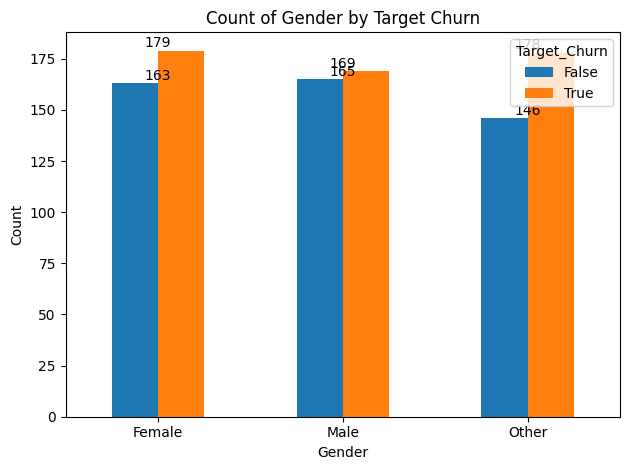

In [18]:
gender_churn_counts = (
    data.groupby(['Gender', 'Target_Churn'])['Gender']
    .count()
    .unstack(fill_value=0)
)

# Create a bar chart
gender_churn_counts.plot(kind='bar', stacked=False)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Count of Gender by Target Churn')

# Add labels for each bar (optional)
for col in gender_churn_counts.columns:
    for i, v in enumerate(gender_churn_counts[col]):
        plt.text(i, v + 0.1, str(v), va='bottom', ha='center', fontsize=10)

plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

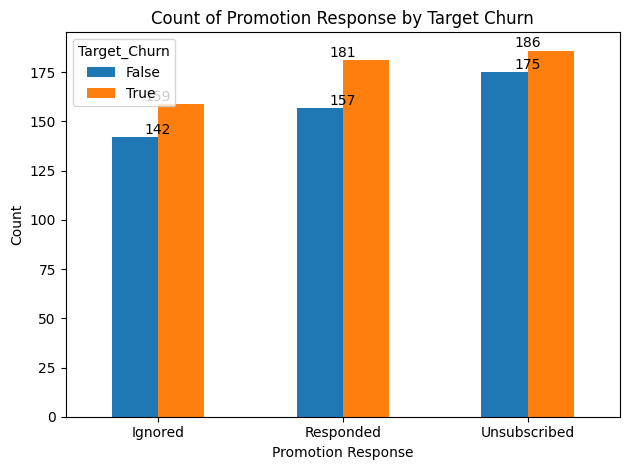

In [19]:
response_churn_counts = (
    data.groupby(['Promotion_Response', 'Target_Churn'])['Promotion_Response']
    .count()
    .unstack(fill_value=0)
)

# Create a bar chart
response_churn_counts.plot(kind='bar', stacked=False)
plt.xlabel('Promotion Response')
plt.ylabel('Count')
plt.title('Count of Promotion Response by Target Churn')

# Add labels for each bar (optional)
for col in response_churn_counts.columns:
    for i, v in enumerate(response_churn_counts[col]):
        plt.text(i, v + 0.1, str(v), va='bottom', ha='center', fontsize=10)

plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [20]:
contingency_table_gender = pd.crosstab(
    data['Gender'],
    data['Target_Churn'],
    margins = False)

contingency_table_gender

Target_Churn,False,True
Gender,,
Female,163,179
Male,165,169
Other,146,178


In [21]:
contingency_table_promotion = pd.crosstab(
    data['Promotion_Response'],
    data['Target_Churn'],
    margins = False)

contingency_table_promotion

Target_Churn,False,True
Promotion_Response,,
Ignored,142,159
Responded,157,181
Unsubscribed,175,186


 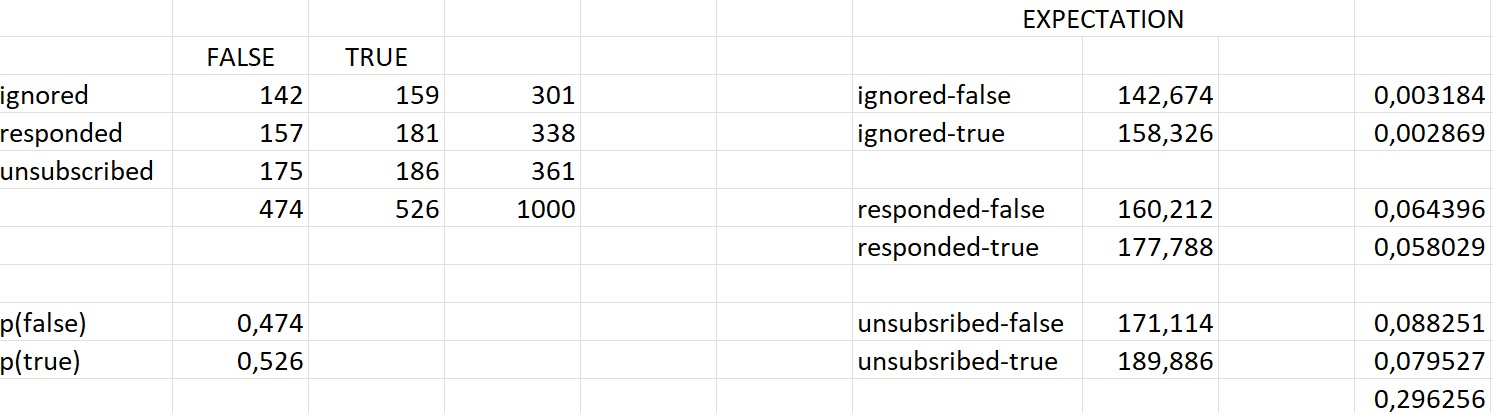

Dapat terlihat bahwa angka churn = True untuk customer yang melakukan respon berupa unsubscribed terhadap promosi merupakan angka yang paling tinggi. Oleh karena itu, fitur promotion response tidak dapat digunakan untuk melakukan prediksi terhadap customer churn.

Berdasarkan feature selection yang telah dilakukan, baik pada fitur numerikal ataupun kategorikal, fitur yang akan digunakan untuk melakukan prediksi customer churn adalah **Annual_Income	Num_of_Purchases, Years_as_Customer, Years_as_Customer, Total_Spend, Average_Transaction_Amount, Satisfaction_Score dan Gender**

## Split dataset

In [22]:
data_selected = data_scaled[['Annual_Income', 'Num_of_Purchases', 'Years_as_Customer', 'Total_Spend', 'Average_Transaction_Amount', 'Satisfaction_Score', 'Gender', 'Target_Churn']]
data_selected

,Annual_Income,Num_of_Purchases,Years_as_Customer,Total_Spend,Average_Transaction_Amount,Satisfaction_Score,Gender,Target_Churn
0,0.139884,0.214286,0.222222,0.584755,0.906422,0.50,Other,True
1,0.331071,0.775510,0.666667,0.901506,0.025434,0.50,Male,False
2,0.051079,0.714286,0.666667,0.051552,0.081924,0.25,Male,True
3,0.331738,0.326531,0.111111,0.910083,0.820613,1.00,Other,True
4,0.320777,0.428571,0.777778,0.534031,0.185500,1.00,Other,False
...,...,...,...,...,...,...,...,...
995,0.688349,0.285714,0.055556,0.099098,0.137576,0.25,Male,False
996,0.802248,0.908163,0.444444,0.363099,0.049048,0.75,Male,True
997,0.519141,0.693878,0.888889,0.060351,0.361698,0.00,Female,False
998,0.294736,0.306122,0.333333,0.382446,0.967758,1.00,Male,True


In [23]:
# Label encode

label_enc = { "Gender": {"Female": 1, "Male": 0, "Other": 2},
             "Target_Churn": {True: 1, False: 0}}
data_selected = data_selected.replace(label_enc)

In [267]:
def add_gaussian_noise(data, mu=3, sigma=0.1):
  """
  Adds Gaussian noise to a NumPy array (tabular data).

  Args:
      data (np.ndarray): The NumPy array representing your tabular data.
      mu (float, optional): Mean of the Gaussian noise distribution (default: 0).
      sigma (float, optional): Standard deviation of the Gaussian noise distribution (default: 0.1).

  Returns:
      np.ndarray: The NumPy array with Gaussian noise added to each feature (column).
  """

  # Check if data is a NumPy array
  if not isinstance(data, np.ndarray):
    raise TypeError("Input data must be a NumPy array.")

  # Generate noise with the specified mean and standard deviation
  noise = np.random.normal(loc=mu, scale=sigma, size=data.shape)

  # Add noise to each feature (column) independently
  noisy_data = data + noise

  return noisy_data

data_augmented = data_selected.copy()
data_augmented = data_augmented[['Annual_Income', 'Num_of_Purchases', 'Years_as_Customer', 'Total_Spend', 'Average_Transaction_Amount', 'Satisfaction_Score',  'Gender']].apply(lambda col: add_gaussian_noise(col.values, 3, 0.1), axis=0)

In [268]:
X = data_augmented
y = data_selected['Target_Churn']

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

In [223]:
X_train

,Annual_Income,Num_of_Purchases,Years_as_Customer,Total_Spend,Average_Transaction_Amount,Satisfaction_Score,Gender
811,3.462540,3.889870,3.821837,3.566856,3.049423,3.364867,5.028903
76,3.292410,3.592350,3.738711,3.306719,3.690492,3.232746,4.089989
636,3.063595,2.915249,3.599916,3.990713,3.683660,3.510175,2.969124
973,3.261015,3.374886,3.332321,3.075552,3.105166,3.174303,5.049994
938,3.989471,4.067498,3.930097,3.298930,3.743128,3.478415,2.965433
...,...,...,...,...,...,...,...
106,3.435746,3.149351,3.251152,3.892234,3.794740,3.267159,4.107163
270,2.972424,3.275948,3.983786,3.857111,3.796724,2.906325,3.956457
860,3.477153,3.390181,3.400953,3.439468,3.171424,3.720410,3.000044
435,3.857156,3.695181,3.005238,3.477138,3.275625,4.045689,3.011873


## Scikit

In [224]:
from sklearn.metrics import precision_score, \
    recall_score, classification_report, \
    accuracy_score, f1_score


def evaluate_classifier_performance(prediction, y_test):
    # Informasi evaluasi secara compact
    print("Hasil Evaluasi berdasarkan classification report \n\n%s\n" % (classification_report(y_test, prediction,zero_division=0)))
    print()
    print("Confusion Matrix")
    print()
    y_actual = pd.Series(np.array(y_test), name = "actual")
    y_pred = pd.Series(np.array(prediction), name = "prediction")
    df_confusion = pd.crosstab(y_actual, y_pred)
    display(df_confusion)
    print()
    print()

    print("Butuh informasi lebih lengkap? silakan simak di bawah ini : ")
    print('Accuracy Average:', accuracy_score(y_test, prediction))
    print('F1 Macro Average:', f1_score(y_test, prediction, average='macro'))
    print('F1 Micro Average:', f1_score(y_test, prediction, average='micro'))
    print('Precision Macro Average:', precision_score(y_test, prediction, average='macro',zero_division=0))
    print('Precision Micro Average:', precision_score(y_test, prediction, average='micro',zero_division=0))
    print('Recall Macro Average:', recall_score(y_test, prediction, average='macro',zero_division=0))
    print('Recall Micro Average:', recall_score(y_test, prediction, average='micro',zero_division=0))
    print()

### SGD

In [225]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# Melakukan proses grid search untuk Random Forest Classifier
param_grid_sgd = {
    'loss': ['log_loss', 'hinge', 'modified_huber'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': np.logspace(-4, 4, 10),  # Range of alpha values to explore (use appropriate range for other parameters)
}
sgd = SGDClassifier()
gs_sgd = GridSearchCV(estimator= sgd, param_grid=param_grid_sgd, cv= 5)
gs_sgd.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(),
             param_grid={'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'loss': ['log_loss', 'hinge', 'modified_huber'],
                         'penalty': ['l1', 'l2', 'elasticnet']})

In [226]:
best_sgd = SGDClassifier(**gs_sgd.best_params_)
best_sgd.fit(X_train, y_train)

SGDClassifier(loss='log_loss', penalty='l1')

In [227]:
# Melakukan prediksi menggunakan random forest
sg_pred = best_sgd.predict(X_test)
evaluate_classifier_performance(sg_pred, y_test)

Hasil Evaluasi berdasarkan classification report 

              precision    recall  f1-score   support

           0       0.20      1.00      0.33         2
           1       0.00      0.00      0.00         8

    accuracy                           0.20        10
   macro avg       0.10      0.50      0.17        10
weighted avg       0.04      0.20      0.07        10



Confusion Matrix



prediction,0
actual,
0,2
1,8




Butuh informasi lebih lengkap? silakan simak di bawah ini : 
Accuracy Average: 0.2
F1 Macro Average: 0.16666666666666669
F1 Micro Average: 0.20000000000000004
Precision Macro Average: 0.1
Precision Micro Average: 0.2
Recall Macro Average: 0.5
Recall Micro Average: 0.2



### KNN

In [228]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

# Mengatur jumlah neighbor yang digunakan.
# N_NEIGHBORS = 5

# Mengatur jumlah pelatihan pada fold fold yang ada.
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

In [229]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'jaccard']
}

gs_knn = GridSearchCV(estimator= knn, param_grid=param_grid_knn, scoring="accuracy", cv=kfold)
gs_knn.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski',
                                    'jaccard'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [230]:
best_knn = KNeighborsClassifier(**gs_knn.best_params_)
best_knn.fit(X_train, y_train)

KNeighborsClassifier(metric='jaccard', n_neighbors=1)

In [231]:
pred_knn = best_knn.predict(X_test)
evaluate_classifier_performance(pred_knn, y_test)

Hasil Evaluasi berdasarkan classification report 

              precision    recall  f1-score   support

           0       0.20      1.00      0.33         2
           1       0.00      0.00      0.00         8

    accuracy                           0.20        10
   macro avg       0.10      0.50      0.17        10
weighted avg       0.04      0.20      0.07        10



Confusion Matrix



prediction,0
actual,
0,2
1,8




Butuh informasi lebih lengkap? silakan simak di bawah ini : 
Accuracy Average: 0.2
F1 Macro Average: 0.16666666666666669
F1 Micro Average: 0.20000000000000004
Precision Macro Average: 0.1
Precision Micro Average: 0.2
Recall Macro Average: 0.5
Recall Micro Average: 0.2



### Naive Bayes

In [279]:
from sklearn.naive_bayes import GaussianNB

param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
}
model_gnb = GaussianNB()
grid_search = GridSearchCV(estimator=model_gnb, param_grid=param_grid_nb, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                           0.0001, 0.001, 0.01, 0.1, 1]},
             scoring='accuracy')

In [280]:
best_nb = GaussianNB(**grid_search.best_params_)
best_nb.fit(X_train, y_train)

GaussianNB(var_smoothing=0.1)

In [281]:
y_pred_nb = best_nb.predict(X_test)

# evaluate_classifier_performance(y_pred,y_test)
print("Accuracy: ", accuracy_score(y_test, y_pred_nb))

Accuracy:  0.8


In [282]:
evaluate_classifier_performance(y_pred_nb, y_test)

Hasil Evaluasi berdasarkan classification report 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.80      1.00      0.89         8

    accuracy                           0.80        10
   macro avg       0.40      0.50      0.44        10
weighted avg       0.64      0.80      0.71        10



Confusion Matrix



prediction,1
actual,
0,2
1,8




Butuh informasi lebih lengkap? silakan simak di bawah ini : 
Accuracy Average: 0.8
F1 Macro Average: 0.4444444444444445
F1 Micro Average: 0.8000000000000002
Precision Macro Average: 0.4
Precision Micro Average: 0.8
Recall Macro Average: 0.5
Recall Micro Average: 0.8



In [283]:
import pickle
with open("model_nb.pkl", "wb") as f:
    pickle.dump(best_nb, f, protocol=5)

### Decision Tree

In [236]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

model_dt = DecisionTreeClassifier(random_state=42)

grid_search_dt = GridSearchCV(estimator=model_dt, param_grid=param_grid, cv=kfold, n_jobs=-1, verbose=1)
grid_search_dt.fit(X_train, y_train)

Fitting 4 folds for each of 324 candidates, totalling 1296 fits


GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             verbose=1)

In [237]:
best_hp_dt = DecisionTreeClassifier(**grid_search_dt.best_params_)
best_hp_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5)

In [238]:
y_pred_dt = best_hp_dt.predict(X_test)

# evaluate_classifier_performance(y_pred,y_test)
print("Accuracy: ", accuracy_score(y_test, y_pred_dt))

Accuracy:  0.2


In [239]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize Randomized Search
random_search = RandomizedSearchCV(estimator=model_dt, param_distributions=param_dist, n_iter=100, cv=kfold, n_jobs=-1, verbose=1, random_state=42)

# Fit Randomized Search
random_search.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e083afe1f60>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e083b0c2ad0>},
                   random_state=42, verbose=1)

In [240]:
best_hp_dt2 = DecisionTreeClassifier(**random_search.best_params_)
best_hp_dt2.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=30, min_samples_leaf=5,
                       min_samples_split=8)

In [241]:
y_pred_dt2 = best_hp_dt2.predict(X_test)

# evaluate_classifier_performance(y_pred,y_test)
print("Accuracy: ", accuracy_score(y_test, y_pred_dt2))

Accuracy:  0.3


### Random forest

In [284]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 7, 10],
               'max_depth' : [5, 10, 12, None]}
rf_cla = RandomForestClassifier()
clf_fc = GridSearchCV(estimator= rf_cla,
                   param_grid=param_grid, cv= kfold)
clf_fc.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 12, None],
                         'min_samples_split': [2, 5, 7, 10]})

In [285]:
best_hp_fc = RandomForestClassifier(**clf_fc.best_params_)
best_hp_fc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=10)

In [286]:
# Melakukan prediksi menggunakan random forest
predicted_fc_os = best_hp_fc.predict(X_test)
# evaluate_classifier_performance(predicted_fc_os, y_test)
print("Accuracy: ", accuracy_score(y_test, predicted_fc_os))

Accuracy:  0.3


In [287]:
evaluate_classifier_performance(predicted_fc_os, y_test)

Hasil Evaluasi berdasarkan classification report 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.60      0.38      0.46         8

    accuracy                           0.30        10
   macro avg       0.30      0.19      0.23        10
weighted avg       0.48      0.30      0.37        10



Confusion Matrix



prediction,0,1
actual,,
0,0,2
1,5,3




Butuh informasi lebih lengkap? silakan simak di bawah ini : 
Accuracy Average: 0.3
F1 Macro Average: 0.23076923076923075
F1 Micro Average: 0.3
Precision Macro Average: 0.3
Precision Micro Average: 0.3
Recall Macro Average: 0.1875
Recall Micro Average: 0.3



In [288]:
import pickle
with open("model_rf.pkl", "wb") as f:
    pickle.dump(best_hp_fc, f, protocol=5)

### SVC

In [247]:
model_svc = SVC()
model_svc.fit(X_train,y_train)

SVC()

In [248]:
pred_svc = model_svc.predict(X_test)
print(classification_report(y_test, pred_svc))

              precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.83      0.62      0.71         8

    accuracy                           0.60        10
   macro avg       0.54      0.56      0.52        10
weighted avg       0.72      0.60      0.64        10



In [249]:
cm = metrics.confusion_matrix(y_test, pred_svc)

TN = cm[0, 0]
TP = cm[1, 1]
FN = cm[1, 0]
FP = cm[0, 1]

print("True Negatives:", TN)
print("True Positives:", TP)
print("False Negatives:", FN)
print("False Positives:", FP)

True Negatives: 1
True Positives: 5
False Negatives: 3
False Positives: 1


In [250]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf'],
              'tol': [0.01, 0.001, 0.0001]}

grid = GridSearchCV(model_svc, param_grid, refit = True, verbose = 0)
grid.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf'], 'tol': [0.01, 0.001, 0.0001]})

In [251]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf', 'tol': 0.01}
SVC(C=10, gamma=0.1, tol=0.01)


In [252]:
best_svc = SVC(**grid.best_params_)
best_svc.fit(X_train,y_train)
grid_predictions = best_svc.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.88      0.88      0.88         8

    accuracy                           0.80        10
   macro avg       0.69      0.69      0.69        10
weighted avg       0.80      0.80      0.80        10



In [253]:
import pickle
with open("model_svc.pkl", "wb") as f:
    pickle.dump(best_svc, f, protocol=5)

In [254]:
cm = metrics.confusion_matrix(y_test, grid_predictions)

TN = cm[0, 0]
TP = cm[1, 1]
FN = cm[1, 0]
FP = cm[0, 1]

print("True Negatives:", TN)
print("True Positives:", TP)
print("False Negatives:", FN)
print("False Positives:", FP)

True Negatives: 1
True Positives: 7
False Negatives: 1
False Positives: 1


### Logistic Regression

In [255]:
logistic = LogisticRegression(max_iter=1000)
logistic.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [256]:
y_logistic_predict = logistic.predict(X_test)
print(classification_report(y_test, y_logistic_predict))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.80      1.00      0.89         8

    accuracy                           0.80        10
   macro avg       0.40      0.50      0.44        10
weighted avg       0.64      0.80      0.71        10



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [257]:
cm = metrics.confusion_matrix(y_test, y_logistic_predict)

TN = cm[0, 0]
TP = cm[1, 1]
FN = cm[1, 0]
FP = cm[0, 1]

print("True Negatives:", TN)
print("True Positives:", TP)
print("False Negatives:", FN)
print("False Positives:", FP)

True Negatives: 0
True Positives: 8
False Negatives: 0
False Positives: 2


### Gradient Boosting

In [258]:
gbc = GradientBoostingClassifier(n_estimators=300,
                                 learning_rate=0.05,
                                 random_state=100,
                                 max_features=7)
gbc.fit(X_train, y_train)

pred_y = gbc.predict(X_test)

acc = metrics.accuracy_score(y_test, pred_y)
print("Gradient Boosting Classifier accuracy is : {:.2f}".format(acc))

Gradient Boosting Classifier accuracy is : 0.50


### Adaboost Classifier

In [259]:
adb = AdaBoostClassifier()
adb_model = adb.fit(X_train,y_train)
print("The accuracy of the model on validation set is", adb_model.score(X_test,y_test))

The accuracy of the model on validation set is 0.6
